In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, confusion_matrix
from skimage import io
 
import import_helper
import_helper.add_functions()
import neuruloid_segmentation.segment_and_save as seg
import neuruloid_segmentation.segmentation_accuracy as acc

### Quantifying accuracy of segmentation
Ways of comparing segmentations:
- Intersection over Union (Jaccard Index)
- Dice Coefficient - F1 score
- Pixel wise accuracy = TP + TN / (TP + TN + FP + FN)
- ROI wise accuracy - Sensitivity, precision and f1 score




In [2]:
# list images in a folder
folder_path = "../image/partial_slice_test"
images = [image.removesuffix(".tif") for image in os.listdir(folder_path) if image.endswith(".tif")]
print(images)

image_path = os.path.join(folder_path, f"{images[0]}.tif")
dapi_image = io.imread(image_path)

model_mask_path = os.path.join(folder_path, f"masks/{images[0]}_masks_model.png")
model_mask = io.imread(model_mask_path)

truth_mask_path = os.path.join(folder_path, f"masks/{images[0]}_masks_ground_truth.png")
truth_mask = io.imread(truth_mask_path)

['slice_test_1', 'slice_test_2']


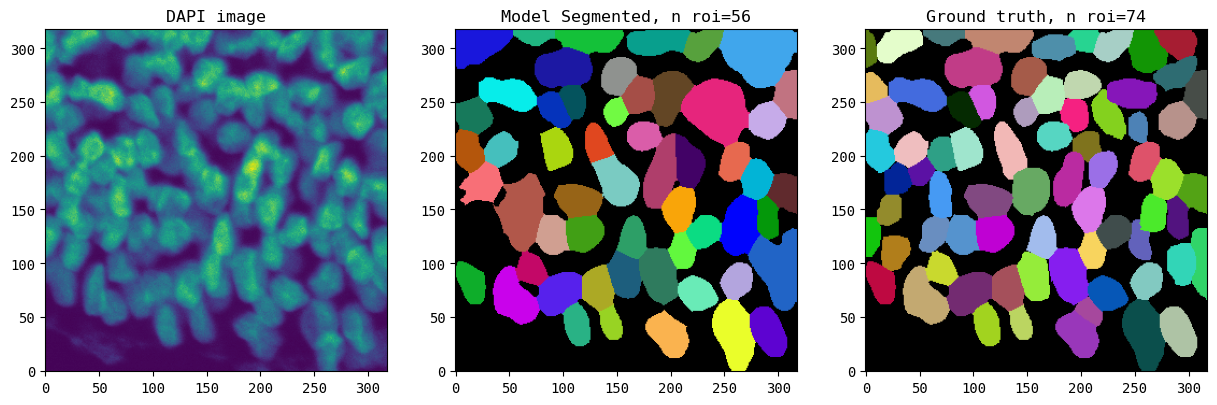

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].set_title(f"DAPI image")
ax[0].imshow(dapi_image, origin="lower")
ax[1].set_title(f"Model Segmented, n roi={len(np.unique(model_mask))}")
seg.plot_mask(model_mask, ax[1], axis="on")
ax[2].set_title(f"Ground truth, n roi={len(np.unique(truth_mask))}")
seg.plot_mask(truth_mask, ax[2], axis="on")

In [4]:
# PIXEL-WISE comparing masks
pred = (model_mask>0).flatten()
truth = (truth_mask>0).flatten()

iou = jaccard_score(truth, pred)
print(f"Intersection over union score {iou:.4f}.")

dice = f1_score(truth, pred)
print(f"Dice coeff {dice:.4f}.")

# Compute pixel-wise accuracy
accuracy = accuracy_score(truth, pred)
print(f"Pixel-wise Accuracy: {accuracy:.4f}")

# Compute confusion matrix (TP, FP, FN, TN)
tn, fp, fn, tp = confusion_matrix(truth, pred).ravel()
print(f"Confusion Matrix: TP={tp}, FP={fp}, FN={fn}, TN={tn}")

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
print(f"Sensitivity: {sensitivity:.4f}, specificity: {specificity:.4f}, precision: {precision:.4f}.")

Intersection over union score 0.8609.
Dice coeff 0.9252.
Pixel-wise Accuracy: 0.9094
Confusion Matrix: TP=56712, FP=3977, FN=5187, TN=35248
Sensitivity: 0.9162, specificity: 0.8986, precision: 0.9345.


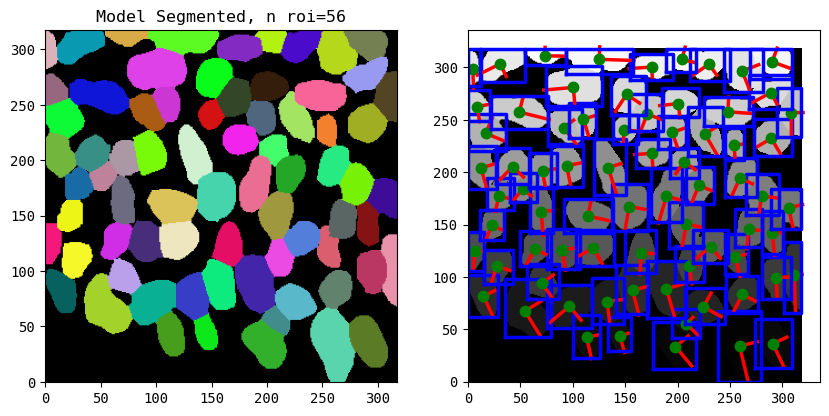

In [5]:
# ROI-wise comparing masks
from skimage.measure import label, regionprops
import math
mask_to_plot = truth_mask

labelled = label(mask_to_plot)
regions = regionprops(labelled)

fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].set_title(f"Model Segmented, n roi={len(np.unique(model_mask))}")
seg.plot_mask(mask_to_plot, ax[0], axis="on")

ax[1].imshow(labelled, cmap=plt.cm.gray, origin="lower")

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax[1].plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax[1].plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax[1].plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax[1].plot(bx, by, '-b', linewidth=2.5)
plt.show()

In [6]:
metrics_dict = acc.compute_roi_metrics(truth_mask, model_mask, iou_threshold=0.5)

In [7]:
print(metrics_dict)

{'True Positives': np.int64(49), 'False Positives': np.int64(6), 'False Negatives': np.int64(24), 'Sensitivity (Recall)': np.float64(0.6712328767123288), 'Precision': np.float64(0.8909090909090909), 'F1-score': np.float64(0.7656250000000001)}
